In [1]:
import hypernetx as hnx
import matplotlib as mp
import matplotlib.pyplot as plt
import networkx as nx
import qf.cc
import qf.graphs
import qf.morph
import numpy as np
import tempfile
from IPython.display import Image
%matplotlib inline

In [2]:
def add_directed_hyperedge(H, sources, target):
    """
    Adds a directed hyperarc to the hypergraph H. The corresponding edge has all sources (a list of nodes)
    and target as endpoints. The special property 'target' is associated with the edge, whose value is the target.
    
    Args:
        H: a `hypernetx.Hypergraph`.
        sources: a list containing the source nodes.
        target: the target node.
    """
    H.add_edge(hnx.Entity(H.number_of_edges(), sources + [target], props={'target': target}))

def add_directed_hyperedges(H, stpairs):
    """
    Adds a list directed hyperarcs, each specified as a pair (sources, target).
    
    Args:
        H: a `hypernetx.Hypergraph`.
        stpairs: a list containing the arcs to be added, each specified by a pair (the first element
        being a list of sources and the target being the target).
    """
    for st in stpairs:
        add_directed_hyperedge(H, st[0], st[1])

In [3]:
def hg2g(H):
    """
    Returns the RB-graph representation of a hypergraph.
    
    Args:
        H: a `hypernetx.Hypergraph`, all of whose hyperedges contain a target propery, that contains the target node.
        
    Returns:
        - the graph.
        - a dictionary mapping the nodes of the returned graph to 0 (blue nodes, i.e., nodes of H) or to 1 (red nodes, i.e., hyperarcs of H).
    """
    G = nx.MultiDiGraph()
    G.add_nodes_from([x.uid for x in H.nodes()])
    G.add_nodes_from([x.uid for x in H.edges()])
    dd1 = {x.uid: 0 for x in H.nodes()} # Blue nodes
    dd2 = {x.uid: 1 for x in H.edges()} # Red nodes
    dd = {**dd1, **dd2}
    for h in H.edges():
        target = h.props['target']
        for i,e in enumerate(h.elements):
            if e != target:
                G.add_edge(e, h.uid, label='(%s,%d,%s)' % (e, i, h.uid))
            else:
                G.add_edge(h.uid, e, label='(%s,%s)' % (h.uid, e))
    return G, dd

In [67]:
posDict = {}

def _visualize_hg(H, png_filename, colors = None):
    """
        Visualizes a given hypergraph.
        
        Args:
            H: a `hypernetx.Hypergraph`, all of whose hyperedges contain a target propery, that contains the target node.
            colors: a dictionary of colors (i.e., values for each node; same value imply same color).
    """
    if colors is None:
        colors = {v.uid: 0 for v in H.nodes()}
    ncols = max(
                max(set(colors.values()))+1, 
                H.number_of_edges()
            )
    cols = np.vstack([[0,0,0,1],plt.cm.tab10(np.arange(40))]) # 0 is black
    plt.ioff()
    fig, ax = plt.subplots()
    if H in posDict:
        posnodes = posDict[H]
    else:
        posnodes = hnx.drawing.rubber_band.layout_node_link(H)
        posDict[H] = posnodes
    hnx.drawing.draw(H, 
                 pos = posnodes, ax=ax,
                 with_edge_labels=False,
                 edges_kwargs={
                     'edgecolors': [cols[h.uid] for h in H.edges()]
                 },
                 nodes_kwargs={
                     'facecolors': [cols[colors[v.uid]] for v in H.nodes()]
                 }
                )
    for h in H.edges():
        target = h.props['target']
        xtarget = posnodes[target][0]
        ytarget = posnodes[target][1]
        for e in h.elements:
            if e != target:
                xsource = posnodes[e][0]
                ysource = posnodes[e][1]
                dx = xtarget - xsource
                dy = ytarget - ysource
                ax.arrow(xsource, ysource, dx, dy, head_width=.03, head_length=.03, 
                         length_includes_head=True, color=cols[h.uid])
    plt.savefig(png_filename, format="PNG")

def visualize_hg(H, colors = None):
    png_filename = tempfile.NamedTemporaryFile(suffix=".png").name
    _visualize_hg(H, png_filename, colors = colors)
    return Image(filename=png_filename)

def save_hg(H, png_filename, colors = None):
    _visualize_hg(H, png_filename, colors = colors)

In [68]:
def hyper_cardon_crochemore(H):
    G, dd = hg2g(H)
    return qf.cc.cardon_crochemore(G, starting_label=dd)

In [69]:
H = hnx.Hypergraph()
add_directed_hyperedges(H, [
    (['FN'], 'TH'),
    (['TH'], 'JV'),
    (['BM', 'FN'], 'JA'),
    (['JV', 'JU', 'CH'], 'BM'),
    (['JU', 'CH', 'BR', 'CN', 'CC', 'JV'], 'BM'),
    (['TH'], 'GP'),
    (['GP'], 'MP'),
    (['MA'], 'GP')
])

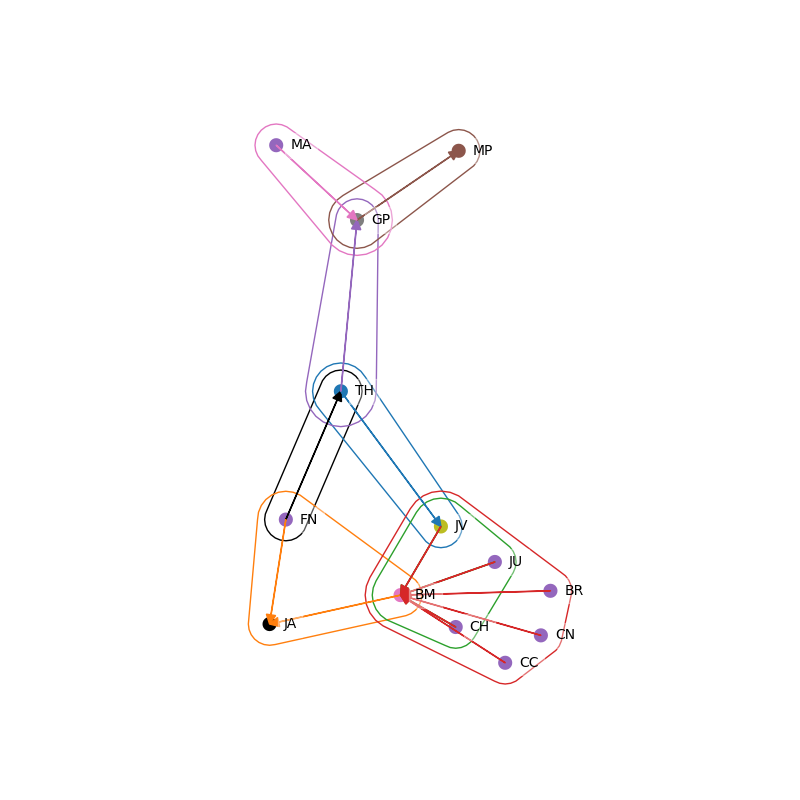

In [71]:
visualize_hg(H, hyper_cardon_crochemore(H))

In [72]:
save_hg(H, "/tmp/hypergraph_example.png", hyper_cardon_crochemore(H))

In [60]:
H = hnx.Hypergraph()
n = 10
d = 3
for x in range(n):
    s = []
    for y in range(d):
        s += ["A{}".format((x+y) % n)]
    add_directed_hyperedge(H, s, "B")


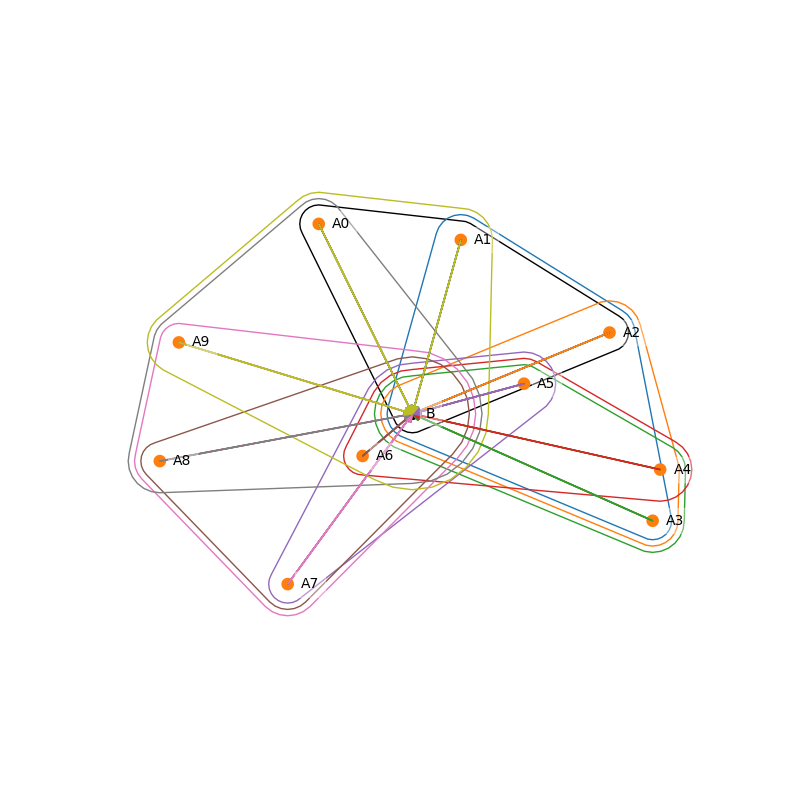

In [61]:
cc = hyper_cardon_crochemore(H)
visualize_hg(H, cc)

In [62]:
add_directed_hyperedge(H, ["B", "A7", "A9"], "A6")

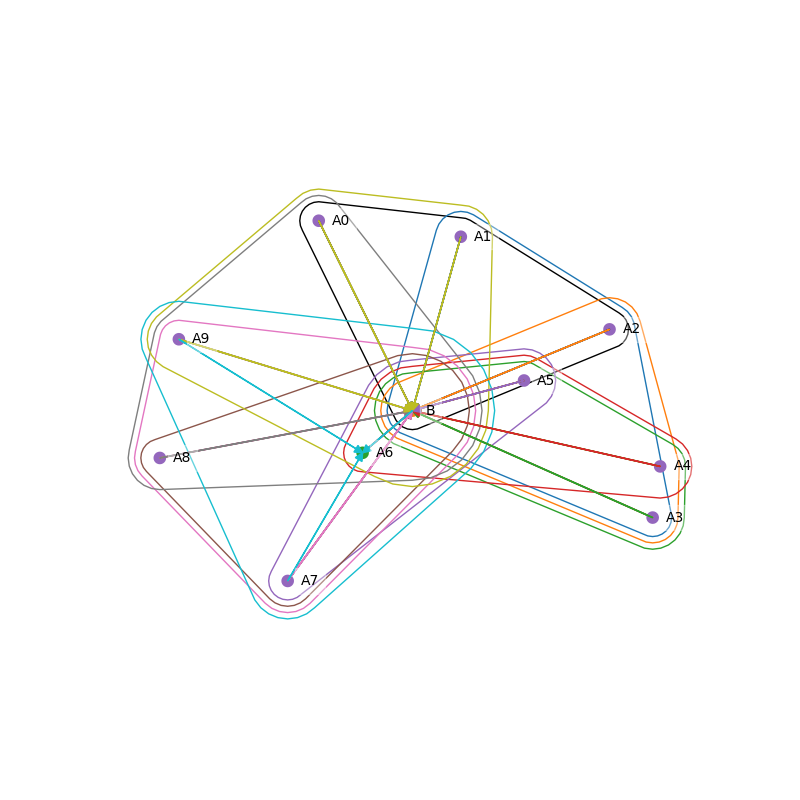

In [63]:
visualize_hg(H,hyper_cardon_crochemore(H))

In [65]:
cc[10]=cc[0]
cc['B']=cc['A0']
G1, dd = hg2g(H)
qf.morph.qf_build(G1, cc, verbose=True)

2 -> 1: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3] median 3 [[[('A0', 0), ('A1', 0), ('A2', 0)], [('A1', 1), ('A2', 1), ('A3', 1)], [('A2', 2), ('A3', 2), ('A4', 2)], [('A3', 3), ('A4', 3), ('A5', 3)], [('A4', 4), ('A5', 4), ('A6', 4)], [('A5', 5), ('A6', 5), ('A7', 5)], [('A6', 6), ('A7', 6), ('A8', 6)], [('A7', 7), ('A8', 7), ('A9', 7)], [('A0', 8), ('A8', 8), ('A9', 8)], [('A0', 9), ('A1', 9), ('A9', 9)], [('B', 10), ('A7', 10), ('A9', 10)]]]
1 -> 2: [0, 0, 0, 10, 0, 0, 0, 1, 0, 0, 0] median 0 [[[], [], [], [(0, 'B'), (1, 'B'), (2, 'B'), (3, 'B'), (4, 'B'), (5, 'B'), (6, 'B'), (7, 'B'), (8, 'B'), (9, 'B')], [], [], [], [(10, 'A6')], [], [], []]]


(<networkx.classes.multidigraph.MultiDiGraph at 0x13ba3aa60>,
 {'A0': 2,
  'A1': 2,
  'A2': 2,
  'B': 2,
  'A3': 2,
  'A4': 2,
  'A5': 2,
  'A6': 2,
  'A7': 2,
  'A8': 2,
  'A9': 2,
  0: 1,
  1: 1,
  2: 1,
  3: 1,
  4: 1,
  5: 1,
  6: 1,
  7: 1,
  8: 1,
  9: 1,
  10: 1,
  '(A0,0,0)': '2_1_0',
  '(A1,1,0)': '2_1_1',
  '(A2,2,0)': '2_1_2',
  '(A1,0,1)': '2_1_0',
  '(A2,1,1)': '2_1_1',
  '(A3,2,1)': '2_1_2',
  '(A2,0,2)': '2_1_0',
  '(A3,1,2)': '2_1_1',
  '(A4,2,2)': '2_1_2',
  '(A3,0,3)': '2_1_0',
  '(A4,1,3)': '2_1_1',
  '(A5,2,3)': '2_1_2',
  '(A4,0,4)': '2_1_0',
  '(A5,1,4)': '2_1_1',
  '(A6,2,4)': '2_1_2',
  '(A5,0,5)': '2_1_0',
  '(A6,1,5)': '2_1_1',
  '(A7,2,5)': '2_1_2',
  '(A6,0,6)': '2_1_0',
  '(A7,1,6)': '2_1_1',
  '(A8,2,6)': '2_1_2',
  '(A7,0,7)': '2_1_0',
  '(A8,1,7)': '2_1_1',
  '(A9,2,7)': '2_1_2',
  '(A0,2,8)': '2_1_0',
  '(A8,0,8)': '2_1_1',
  '(A9,1,8)': '2_1_2',
  '(A0,1,9)': '2_1_0',
  '(A1,2,9)': '2_1_1',
  '(A9,0,9)': '2_1_2',
  '(B,0,10)': '2_1_0',
  '(A7,1,10)': '